<a href="https://colab.research.google.com/github/adamehayman/AMII/blob/main/2_Decision_Tree_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Decision Tree Classifier Introduction**  
  
Although decision trees may not be the fanciest algorithms out there, they are still a useful tool to visualize the decision-making process. They provide insights into which features are dominating the decisions and results.  
In this example, we wil try to predict 10 different classes, which the emphasis on those that are closer to the actual RUL, as that aligns with our business objective.  
We will import the dataframes from the EDA process in the previous notebook.

In [ ]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
pd.set_option('display.max_rows', 200)
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')

## **Import Data**

In [ ]:
# Clone Git Repo
!git clone -l -s git://github.com/adamehayman/AMII.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 46 (delta 15), reused 37 (delta 9), pack-reused 0
Receiving objects: 100% (46/46), 14.02 MiB | 20.78 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/cloned-repo
1_NASA_FD001_EDA.ipynb	FIgures.pptx  NASA_TurboFan_Data  README.md


In [ ]:
train1_class = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/train1_new.csv')
test1_class = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/test1.csv')

In [ ]:
sensor2keep = ['T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'w31', 'w32']
col2keep = ['Unit', 'T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'w31', 'w32', 'RUL']

In [ ]:
train1_class

,Unit,T24,T30,T50,P15,P30,Ps30,phi,NRf,NRc,BPR,htBleed,w31,w32,RUL
0,1,641.82,1589.70,1400.60,21.61,554.36,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,642.15,1591.82,1403.14,21.61,553.75,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,642.35,1587.99,1404.20,21.61,554.26,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,642.35,1582.79,1401.87,21.61,554.45,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,642.37,1582.85,1406.22,21.61,554.00,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,643.49,1597.98,1428.63,21.61,551.43,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,643.54,1604.50,1433.58,21.61,550.86,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,643.42,1602.46,1428.18,21.61,550.94,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,643.23,1605.26,1426.53,21.61,550.68,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [ ]:
test1_class = test1_class[col2keep]
test1_class

,Unit,T24,T30,T50,P15,P30,Ps30,phi,NRf,NRc,BPR,htBleed,w31,w32,RUL
0,1,643.02,1585.29,1398.21,21.61,553.90,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,641.71,1588.45,1395.42,21.61,554.85,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,642.46,1586.94,1401.34,21.61,554.11,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,642.44,1584.12,1406.42,21.61,554.07,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,642.51,1587.19,1401.92,21.61,554.16,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,643.24,1599.45,1415.79,21.61,553.41,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,24
13092,100,643.22,1595.69,1422.05,21.61,553.22,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,23
13093,100,643.44,1593.15,1406.82,21.61,553.04,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,22
13094,100,643.26,1594.99,1419.36,21.61,553.37,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,21


## **Data Visualization**  
  
Plots of every 10th unit for the two most strongly correlated sensors with RUL, Ps30 and T50

In [ ]:
# Strongest Negative Correlation from previous EDA notebook

str_corr = ['Ps30', 'T50']

In [ ]:
# Function to plot every 10th unit

def plot_sensor(sensor_name):
    plt.figure(figsize=(20,5))
    for i in train1_class['Unit'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train1_class[train1_class['Unit']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

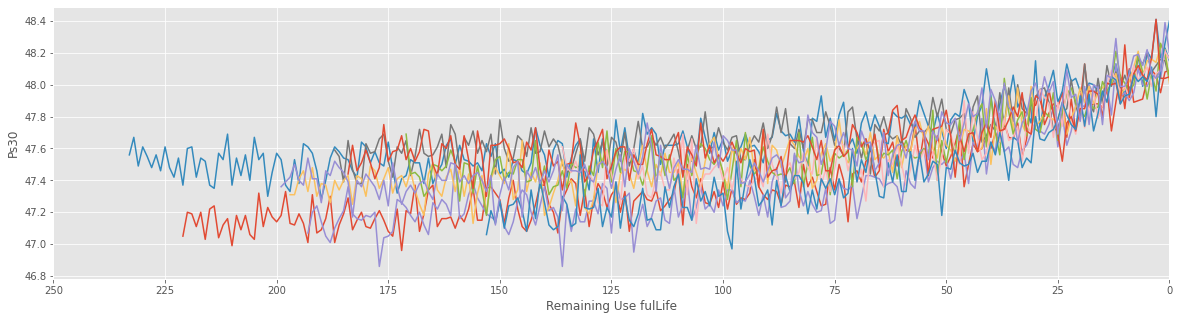

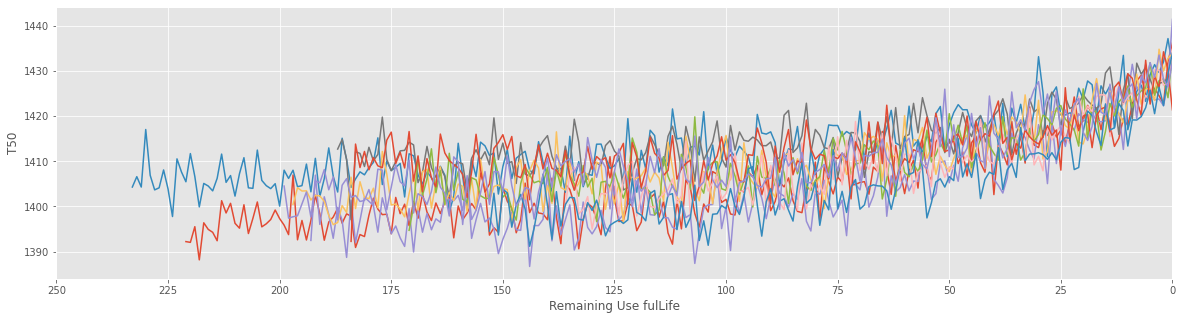

In [ ]:
for sensor_name in str_corr:
    plot_sensor(sensor_name)

## **Label Data Discretization - Creating RUL Classes or Bins for train1 and test1**  
  
Add a new column label for RUL bins: the "boundaries" of these bins are likely to change but as a starting point:  
class 1 = RUL 0-20    
class 2 = RUL 20-40  
class 3 = RUL 40-60    
class 4 = RUL 60-80    
class 5 = RUL 80-100  
class 6 = RUL 100-120  
class 7 = RUL 120-140  
class 8 = RUL 140-160  
class 9 = RUL 160-180  
class 10 = RUL > 180


### **train1_class**

In [ ]:
for ii in range(len(train1_class)):

    curr_RUL = train1_class.loc[ii, 'RUL']

    if curr_RUL >= 0 and curr_RUL < 20:
        train1_class.loc[ii, 'RUL class'] = int(1)
    elif curr_RUL >= 20 and curr_RUL < 40:
        train1_class.loc[ii, 'RUL class'] = int(2)
    elif curr_RUL >= 40 and curr_RUL < 60:
        train1_class.loc[ii, 'RUL class'] = int(3)
    elif curr_RUL >= 60 and curr_RUL < 80:
        train1_class.loc[ii, 'RUL class'] = int(4)
    elif curr_RUL >= 80 and curr_RUL < 100:
        train1_class.loc[ii, 'RUL class'] = int(5)
    elif curr_RUL >= 100 and curr_RUL < 120:
        train1_class.loc[ii, 'RUL class'] = int(6)
    elif curr_RUL >= 120 and curr_RUL < 140:
        train1_class.loc[ii, 'RUL class'] = int(7)
    elif curr_RUL >= 140 and curr_RUL < 160:
        train1_class.loc[ii, 'RUL class'] = int(8)
    elif curr_RUL >= 160 and curr_RUL < 180:
        train1_class.loc[ii, 'RUL class'] = int(9)
    else:
        train1_class.loc[ii, 'RUL class'] = int(10)

In [ ]:
train1_class['RULclass'] = train1_class['RUL class'].astype(int)
train1_class.drop('RUL class', axis=1, inplace=True)

**Split sensor data into classes based on RUL**
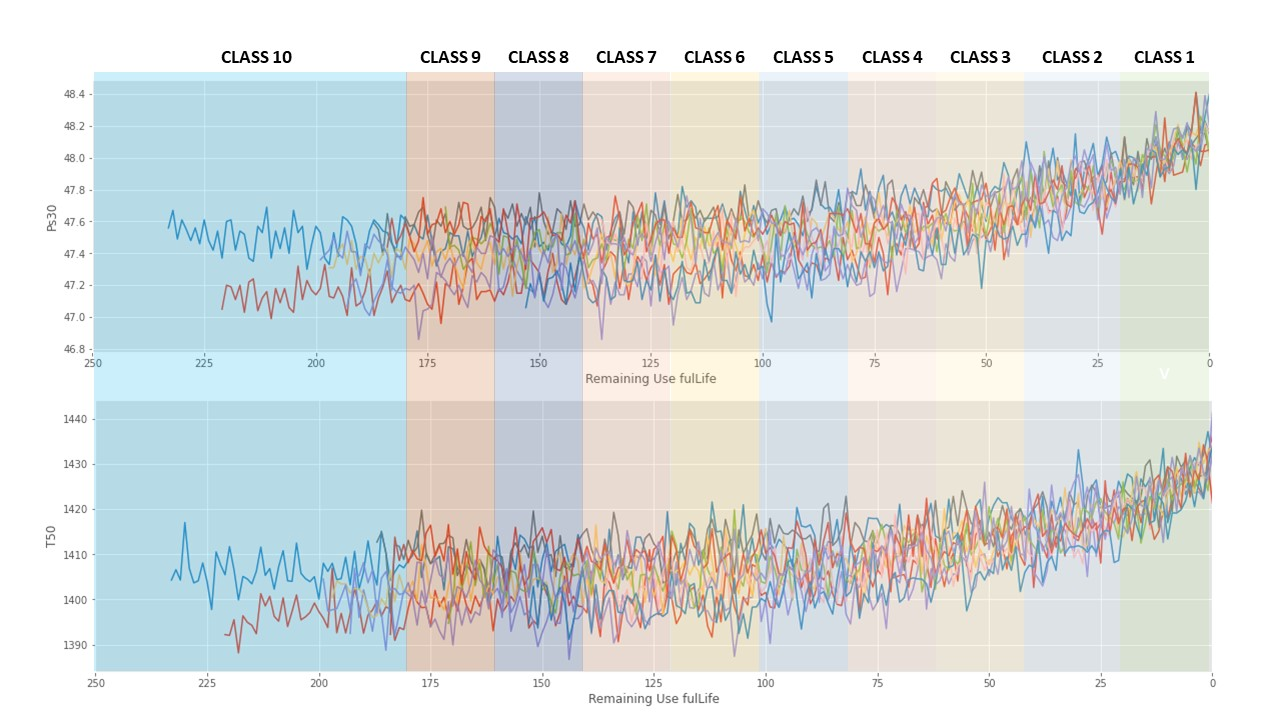

### **test1_class**

In [ ]:
for ii in range(len(test1_class)):

    curr_RUL = test1_class.loc[ii, 'RUL']

    if curr_RUL >= 0 and curr_RUL < 20:
        test1_class.loc[ii, 'RUL class'] = int(1)
    elif curr_RUL >= 20 and curr_RUL < 40:
        test1_class.loc[ii, 'RUL class'] = int(2)
    elif curr_RUL >= 40 and curr_RUL < 60:
        test1_class.loc[ii, 'RUL class'] = int(3)
    elif curr_RUL >= 60 and curr_RUL < 80:
        test1_class.loc[ii, 'RUL class'] = int(4)
    elif curr_RUL >= 80 and curr_RUL < 100:
        test1_class.loc[ii, 'RUL class'] = int(5)
    elif curr_RUL >= 100 and curr_RUL < 120:
        test1_class.loc[ii, 'RUL class'] = int(6)
    elif curr_RUL >= 120 and curr_RUL < 140:
        test1_class.loc[ii, 'RUL class'] = int(7)
    elif curr_RUL >= 140 and curr_RUL < 160:
        test1_class.loc[ii, 'RUL class'] = int(8)
    elif curr_RUL >= 160 and curr_RUL < 180:
        test1_class.loc[ii, 'RUL class'] = int(9)
    else:
        test1_class.loc[ii, 'RUL class'] = int(10)

In [ ]:
test1_class['RULclass'] = test1_class['RUL class'].astype(int)
test1_class.drop('RUL class', axis=1, inplace=True)

### **RULclass Distribution**  
Examine the RULclass distribution so we can create bins for StratifiedShuffleSplit

In [ ]:
fig = px.histogram(train1_class, x='RULclass')
fig.show()

In [ ]:
train1_class['RULclass'].value_counts()

10    3240
6     2000
5     2000
4     2000
3     2000
2     2000
1     2000
7     1977
8     1846
9     1568
Name: RULclass, dtype: int64

From the above class distribution, we can see almost twice as many class 10 instances. Rather than dealing with class imbalance, we will drop all the class 10 instances as they are not crucial to our overall business objective. The class 10 instances are so early in the engine life cycle that they likely will not provide much valuable insight.  
Since we made a RULclass column, we will also have to drop the RUL column or the algorithm will simply use that to predict the RULclass. We will also drop the Unit column as that could lead to invalid predictions.

In [ ]:
train1_class.drop(train1_class.loc[train1_class['RULclass']==10].index, inplace=True)
train1_class.drop(['RUL', 'Unit'], axis=1, inplace=True)

In [ ]:
train1_class.reset_index(drop=True, inplace=True)

In [ ]:
test1_class.drop(test1_class.loc[test1_class['RULclass']==10].index, inplace=True)
test1_class.drop(['RUL', 'Unit'], axis=1, inplace=True)

In [ ]:
test1_class.reset_index(drop=True, inplace=True)

## **Stratified-Shuffle Split**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_index, test_index in split.split(train1_class, train1_class['RULclass']):
  strat_train_set = train1_class.loc[train_index]
  strat_val_set = train1_class.loc[test_index]

In [ ]:
StratSplit = strat_val_set['RULclass'].value_counts() / len(strat_val_set)
Dist = train1_class['RULclass'].value_counts() / len(train1_class)

Create a DataFrame to compare the actual distribution of RULclass vs the distribution obtained form StratifiedShuffleSplit

In [ ]:
df_Compare = pd.DataFrame(columns = ['Stratified Split', 'Actual Distribution', 'Difference'])
df_Compare['Stratified Split'] = StratSplit
df_Compare['Actual Distribution'] = Dist
df_Compare['Difference'] = StratSplit - Dist
df_Compare

,Stratified Split,Actual Distribution,Difference
3,0.114987,0.115002,-0.000015
6,0.114987,0.115002,-0.000015
2,0.114987,0.115002,-0.000015
5,0.114987,0.115002,-0.000015
1,0.114987,0.115002,-0.000015
4,0.114987,0.115002,-0.000015
7,0.113645,0.113679,-0.000034
8,0.106171,0.106147,0.000024
9,0.090264,0.090162,0.000103


In [ ]:
print('Our training set is strat_train_set with shape: ' + str(strat_train_set.shape) + '\n'
'Our validation set is strat_val_set with shape: ' + str(strat_val_set.shape))

Our training set is strat_train_set with shape: (12173, 14)
Our validation set is strat_val_set with shape: (5218, 14)


## **Preapre the Data for Machine Learning Algorithms**

In [ ]:
X_train = strat_train_set.drop('RULclass', axis=1)
y_train = strat_train_set['RULclass'].copy()

In [ ]:
X_val = strat_val_set.drop('RULclass', axis=1)
y_val = strat_val_set['RULclass'].copy()

### **Feature Scaling**  
  
Although feature scaling is not required for decision tress, we will do it for future models.  
We will perform three different feature scaling techniques and visualize our data:
*  MinMax scaling, also called normalization, is where we shift and resclae the values so they range from 0-1. We do this by subtracting the min value and dividing by the max minus the min.
*  Standardization, or StandardScaler in Scikit-Learn, is where we subtract the mean value and then divide by the standard deviation. The resulting distribution has a unit variance—performing StandardScaler results in a mean of 0 +/- 1 standard deviation, which could be a problem for neural networks. On the other hand, standardization is affected much less by outliers.  
*  RobustScaler is one of the best-suited scalers for datasets with outliers. It scales the data according to the interquartile range, which is the middle range where most of the data exists.

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()
scaler_minmax = MinMaxScaler()

It may seem trivial to some, but we will fit_transform the training set only and fit that function to both the validation and test sets to prevent data leakage.

In [ ]:
X_train_std_scaler = scaler_standard.fit_transform(X_train)
X_train_rbt_scaler = scaler_robust.fit_transform(X_train)
X_train_min_scaler = scaler_minmax.fit_transform(X_train)

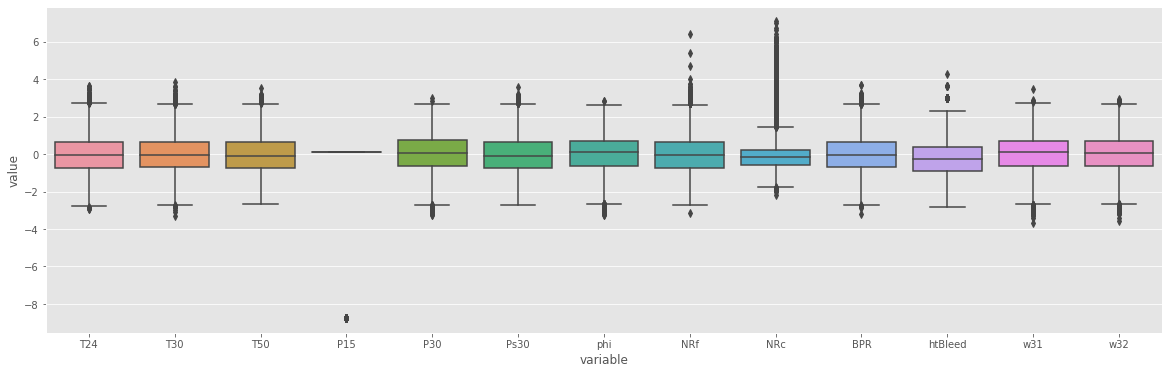

In [ ]:
train1_standard = pd.DataFrame(X_train_std_scaler, columns = sensor2keep)
plt.figure(figsize=(20, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(train1_standard))
plt.show()

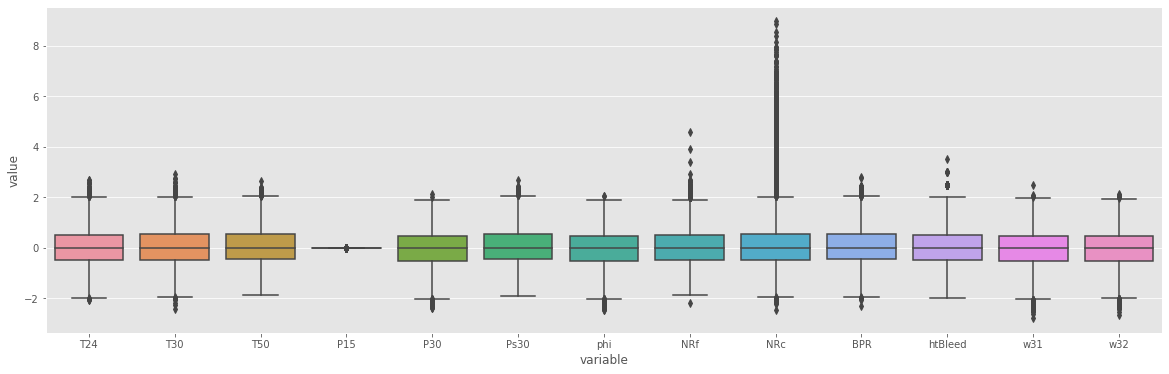

In [ ]:
train1_robust = pd.DataFrame(X_train_rbt_scaler, columns = sensor2keep)
plt.figure(figsize=(20, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(train1_robust))
plt.show()

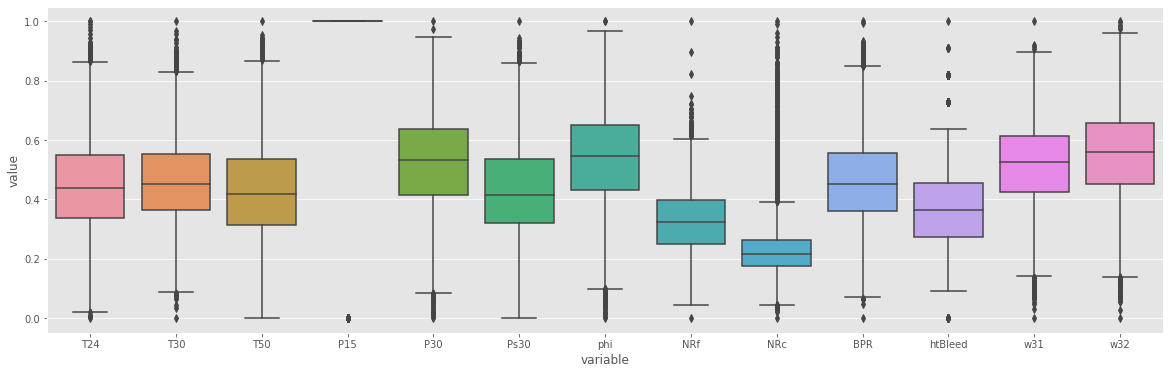

In [ ]:
train1_minmax = pd.DataFrame(X_train_min_scaler, columns = sensor2keep)
plt.figure(figsize=(20, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(train1_minmax))
plt.show()

### **Drop Columns**

From the above feature scaling methods, we can see that NRc (corrected core speed) and P15 (total pressure in bypass-duct) do not have ideal distributions and may cause future problems. Looking back at the EDA, we can see that both features do not correlate very strongly with RUL, -0.31 and -0.13, respectively. We will drop them for now and reconsider these features when performing PCA and variance analysis.

In [ ]:
X_train.drop(['P15', 'NRc'], axis=1, inplace=True)

In [ ]:
X_val.drop(['P15', 'NRc'], axis=1, inplace=True)

In [ ]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

For this dataset, we will compare MinMax and StandardScaler to see how it affects our model.

#### **MinMax Scaling**

In [ ]:
X_train_min_scaler = scaler_minmax.fit_transform(X_train)
X_val_min_scaler = scaler_minmax.transform(X_val)

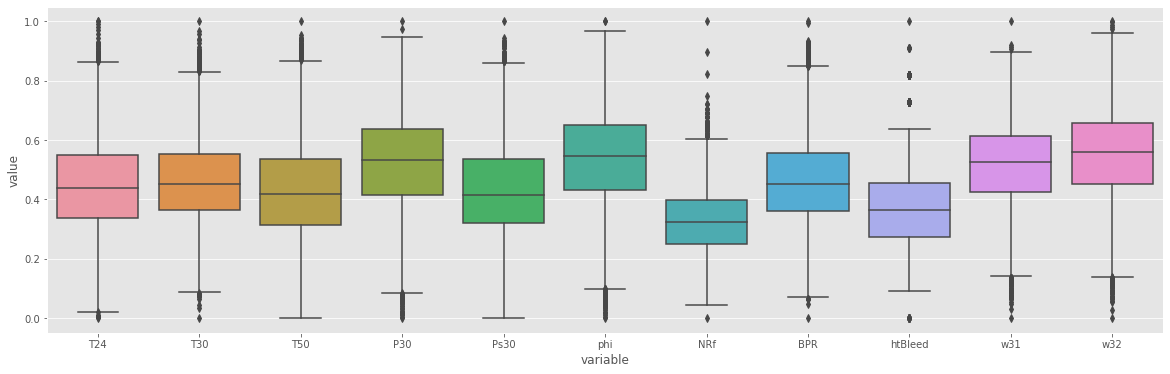

In [ ]:
train1_minmax = pd.DataFrame(X_train_min_scaler, columns = sensors)
plt.figure(figsize=(20, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(train1_minmax))
plt.show()

#### **StandardScaler**

In [ ]:
X_train_std_scaler = scaler_standard.fit_transform(X_train)
X_val_std_scaler = scaler_standard.transform(X_val)

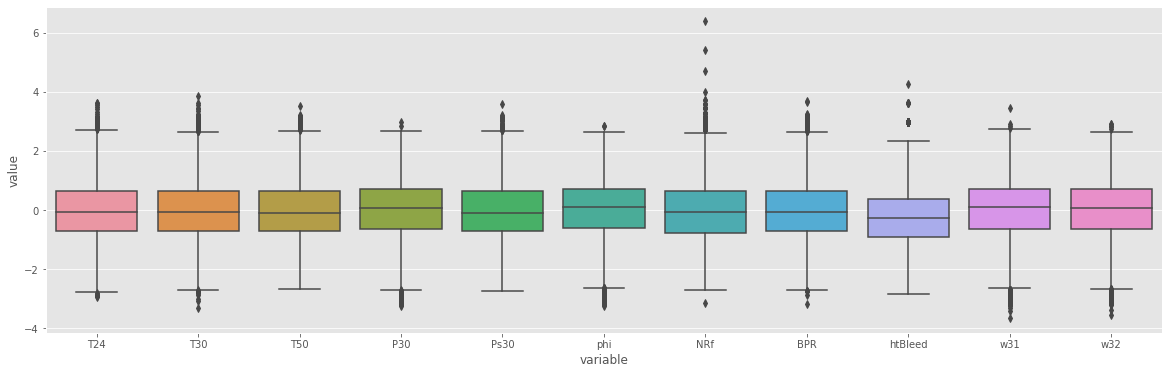

In [ ]:
train1_standard = pd.DataFrame(X_train_std_scaler, columns = sensors)
plt.figure(figsize=(20, 6))
sns.boxplot(x="variable", y="value", data=pd.melt(train1_standard))
plt.show()

## **Train Classification Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, r2_score, precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

### **MinMax Classification Tree**

In [ ]:
DTCmin = DecisionTreeClassifier(random_state=42)

DTCmin.fit(X_train_min_scaler, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
yhat_train_min = DTCmin.predict(X_train_min_scaler)
evaluate(y_train, yhat_train_min, 'train')

train set RMSE:0.0, R2:1.0


In [ ]:
yhat_val_min = DTCmin.predict(X_val_min_scaler)
evaluate(y_val, yhat_val_min)

test set RMSE:2.177096008336156, R2:0.2597089944425103


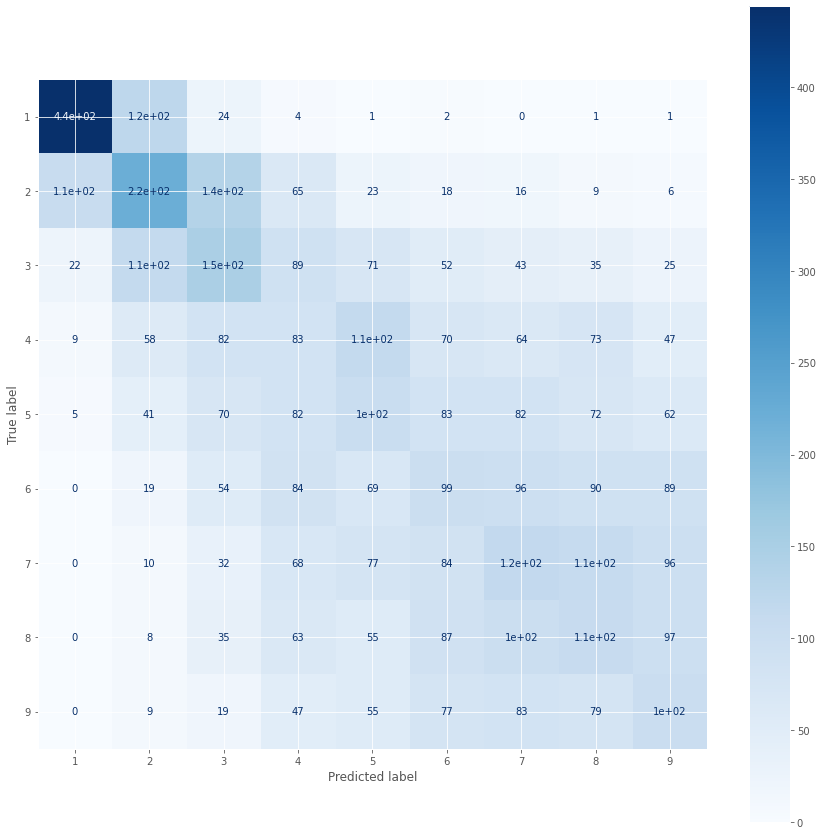

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(DTCmin, X_val_min_scaler, y_val, cmap=plt.cm.Blues, ax=ax)

In [ ]:
precision, recall, fscore, support = score(y_val, yhat_val_min)

print('precision on val: {}'.format(precision))
print('recall on val: {}'.format(recall))
print('fscore on val: {}'.format(fscore))
print('support on test: {}'.format(support))

precision on val: [0.75767918 0.36650083 0.24792013 0.14188034 0.18133803 0.17307692
 0.19333333 0.18858131 0.19428571]
recall on val: [0.74       0.36833333 0.24833333 0.13833333 0.17166667 0.165
 0.19561551 0.1967509  0.21656051]
fscore on val: [0.74873524 0.3674148  0.24812656 0.14008439 0.17636986 0.16894198
 0.19446773 0.19257951 0.20481928]
support on test: [600 600 600 600 600 600 593 554 471]


#### **MinMax GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_dict = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(1, 10),
    'min_samples_split':range(1,10),
    'min_samples_leaf':range(1,5)
}

In [ ]:
DTCminGrid = GridSearchCV(DTCmin,
                          param_grid=param_dict,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)
DTCminGrid.fit(X_train_min_scaler, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                       

In [ ]:
DTCminGrid.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [ ]:
DTCminGrid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
DTCminGrid.best_score_

0.29926847416561075

In [ ]:
DTCminScore = DTCminGrid.best_score_

### **StandardScaler Classification Tree**

In [ ]:
DTCstd = DecisionTreeClassifier(random_state=42)

DTCstd.fit(X_train_std_scaler, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
yhat_train_std = DTCstd.predict(X_train_std_scaler)
evaluate(y_train, yhat_train_std, 'train')

train set RMSE:0.0, R2:1.0


In [ ]:
yhat_val_std = DTCstd.predict(X_val_std_scaler)
evaluate(y_val, yhat_val_std)

test set RMSE:2.17202852975608, R2:0.2631512338747888


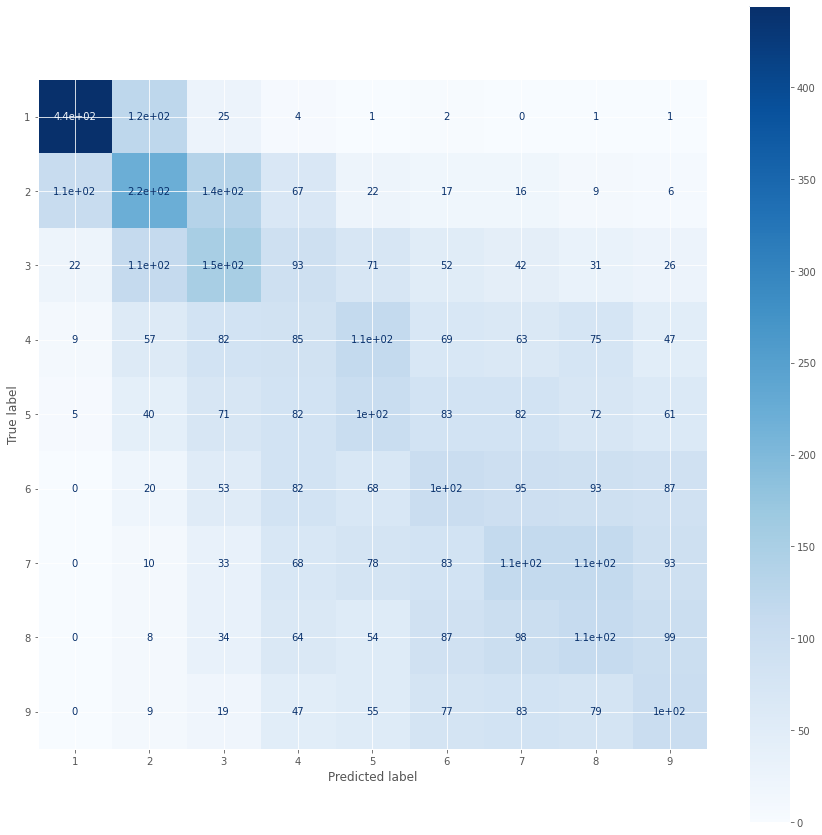

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(DTCstd, X_val_std_scaler, y_val, cmap=plt.cm.Blues, ax=ax)

In [ ]:
precision, recall, fscore, support = score(y_val, yhat_val_std)

print('precision on val: {}'.format(precision))
print('recall on val: {}'.format(recall))
print('fscore on val: {}'.format(fscore))
print('support on val: {}'.format(support))

precision on val: [0.75638842 0.36894825 0.25041459 0.14358108 0.18374558 0.17832168
 0.19224283 0.18835616 0.1954023 ]
recall on val: [0.74       0.36833333 0.25166667 0.14166667 0.17333333 0.17
 0.19224283 0.19855596 0.21656051]
fscore on val: [0.74810447 0.36864053 0.25103907 0.14261745 0.17838765 0.17406143
 0.19224283 0.19332162 0.20543807]
support on val: [600 600 600 600 600 600 593 554 471]


#### **StandardScaler GridSearch**

In [ ]:
DTCstdGrid = GridSearchCV(DTCstd,
                          param_grid=param_dict,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)
DTCstdGrid.fit(X_train_std_scaler, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 2760 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                       

In [ ]:
DTCstdGrid.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [ ]:
DTCstdGrid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
DTCstdGrid.best_score_

0.29918630489691717

In [ ]:
DTCstdScore = DTCstdGrid.best_score_

### **Accuracy Comparison Between MinMax and StandardScaler**

In [ ]:
print('MinMax Scaled Decision Tree Classifier Score:',DTCminScore)
print('StandardScaler Scaled Decision Tree Classifier Score:',DTCstdScore)

MinMax Scaled Decision Tree Classifier Score: 0.29926847416561075
StandardScaler Scaled Decision Tree Classifier Score: 0.29918630489691717


From the above results we can see that the choice of scaling method does not appear to have a significant impact on model accuracy. That being said, we only comapred two scaling methods in depth:
*  MinMax Scaler  
*  StandardScaler  

## **Discussion**  
  
Although the data is a time series analysis, it was an excellent exercise to see if the data could be separated into RUL prediction classes. Although the resulting decision tree classifier model did not perform well, we could still gain valuable insights, such as distribution patterns and the consequential decision to drop sensors P15 and NRc for this particular case.  
  
Future work and areas to explore:  
*  smoothing the data to reduce the effect of noise
*  fusing sensors to create an overall health index of the engine
*  applying an asymmetric loss function that will penalize late predictions  
  
We took a bit of a side trip on the feature scaling section. That was more for interest's sake, but it is good to keep in mind that the choice of scaling method can affect your models' results.   
We will always come back to whether this potential solution aligns with our business objectives. In this case, there were far too many late predictions, increasing the risk of unplanned failures and downtime.